# Theft Detection Notebook (From scratch models)

## Imports

In [211]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score,confusion_matrix, classification_report, roc_auc_score,accuracy_score
from collections import Counter
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms
import multiprocessing
from multiprocessing import Pool
from sklearn.metrics import precision_recall_curve, average_precision_score
from tqdm import tqdm

## Cuda Check

In [212]:
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device count:", torch.cuda.device_count())
    print("Current device index:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("Running on CPU only.")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PyTorch version: 2.8.0+cu128
CUDA available: True
CUDA device count: 1
Current device index: 0
Device name: NVIDIA GeForce RTX 3060 Laptop GPU


## Setup Dataset

In [213]:
# Set WSL-compatible paths
base_path = '/mnt/c/Users/Rowan/Desktop/Cellula_Internship/Task3/Shop Dataset'
print("Base path:", base_path)
print("Exists?", os.path.exists(base_path))
print("Contents of Shop Dataset:", os.listdir(base_path))

non_shoplifting_path = os.path.join(base_path, 'non shop lifters')
shoplifting_path = os.path.join(base_path, 'shop lifters')

print("Non-shoplifting path:", non_shoplifting_path)
print("Exists?", os.path.exists(non_shoplifting_path))
print("Shoplifting path:", shoplifting_path)
print("Exists?", os.path.exists(shoplifting_path))

Base path: /mnt/c/Users/Rowan/Desktop/Cellula_Internship/Task3/Shop Dataset
Exists? True
Contents of Shop Dataset: ['non shop lifters', 'shop lifters']
Non-shoplifting path: /mnt/c/Users/Rowan/Desktop/Cellula_Internship/Task3/Shop Dataset/non shop lifters
Exists? True
Shoplifting path: /mnt/c/Users/Rowan/Desktop/Cellula_Internship/Task3/Shop Dataset/shop lifters
Exists? True


In [214]:
# Function to load video paths and labels
def load_video_paths():
    non_shoplifting_videos = [os.path.join(non_shoplifting_path, f) for f in os.listdir(non_shoplifting_path) if f.endswith(('.mp4', '.avi'))]
    shoplifting_videos = [os.path.join(shoplifting_path, f) for f in os.listdir(shoplifting_path) if f.endswith(('.mp4', '.avi'))]
    videos = non_shoplifting_videos + shoplifting_videos
    labels = [0] * len(non_shoplifting_videos) + [1] * len(shoplifting_videos)
    return videos, labels

videos, labels = load_video_paths()

In [215]:
# Check imbalance
print("Class distribution:", Counter(labels))

Class distribution: Counter({0: 531, 1: 324})


In [216]:
# Balance the data by uniform duplication with minimal augmentation
minority_class = 1 if labels.count(1) < labels.count(0) else 0
majority_count = max(labels.count(0), labels.count(1))
minority_indices = [i for i, label in enumerate(labels) if label == minority_class]
oversample_count = majority_count - len(minority_indices)

if oversample_count > 0:
    # Calculate uniform duplicates per sample
    duplicates_per_sample = oversample_count // len(minority_indices)
    remaining = oversample_count % len(minority_indices)
    
    oversampled_videos = []
    oversampled_labels = []
    for idx in minority_indices:
        video_path = videos[idx]
        # Minimal augmentation: Random horizontal flip with 50% chance
        cap = cv2.VideoCapture(video_path)
        frames = []
        ret, frame = cap.read()
        if ret:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            if random.random() < 0.5:
                frame_rgb = cv2.flip(frame_rgb, 1)  # Horizontal flip
            frames.append(frame_rgb / 255.0)  # Normalize a sample frame for consistency
        cap.release()
        # Duplicate with this minimal change
        oversampled_videos.extend([video_path] * duplicates_per_sample)
        oversampled_labels.extend([1] * duplicates_per_sample)
    
    # Add remaining duplicates from the start
    for idx in minority_indices[:remaining]:
        video_path = videos[idx]
        cap = cv2.VideoCapture(video_path)
        frames = []
        ret, frame = cap.read()
        if ret:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            if random.random() < 0.5:
                frame_rgb = cv2.flip(frame_rgb, 1)
            frames.append(frame_rgb / 255.0)
        cap.release()
        oversampled_videos.append(video_path)
        oversampled_labels.append(1)

    videos.extend(oversampled_videos)
    labels.extend(oversampled_labels)

In [217]:
print("Balanced class distribution:", Counter(labels))

Balanced class distribution: Counter({0: 531, 1: 531})


In [ ]:
fixed_frames = 10
frame_size = (128, 128)
batch_size = 25

In [219]:
# For intensity stabilization: Apply histogram equalization to make CDF more linear
def equalize_frame(frame):
    frame_yuv = cv2.cvtColor(frame, cv2.COLOR_BGR2YUV)
    frame_yuv[:,:,0] = cv2.equalizeHist(frame_yuv[:,:,0])
    return cv2.cvtColor(frame_yuv, cv2.COLOR_YUV2BGR)

In [220]:
def extract_frames(v):
    try:
        cap = cv2.VideoCapture(v)
        frames = []
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if total_frames == 0:
            print(f"Warning: Empty video skipped - {v}")
            cap.release()
            return np.zeros((fixed_frames, frame_size[0], frame_size[1], 3))
        step = max(1, total_frames // fixed_frames)
        for i in range(fixed_frames):
            cap.set(cv2.CAP_PROP_POS_FRAMES, i * step)
            ret, frame = cap.read()
            if not ret:
                frames.append(np.zeros((frame_size[0], frame_size[1], 3)))
                continue
            frame = cv2.resize(frame, frame_size)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) / 255.0  
            frames.append(frame)
        while len(frames) < fixed_frames:
            frames.append(np.zeros((frame_size[0], frame_size[1], 3)))
        cap.release()
        return np.array(frames)
    except Exception as e:
        print(f"Error processing {v}: {e}")
        return np.zeros((fixed_frames, frame_size[0], frame_size[1], 3))

In [221]:
def load_data_in_batches(videos):
    X = []
    for i in tqdm(range(0, len(videos), batch_size), desc="Loading video data"):
        batch_videos = videos[i:i + batch_size]
        batch_X = [extract_frames(v) for v in batch_videos]
        X.append(np.stack(batch_X))
    return np.vstack(X)

In [222]:
X = load_data_in_batches(videos)
y = np.array(labels)

Loading video data:   0%|          | 0/43 [00:00<?, ?it/s]

Loading video data: 100%|██████████| 43/43 [04:53<00:00,  6.82s/it]


## Visualization

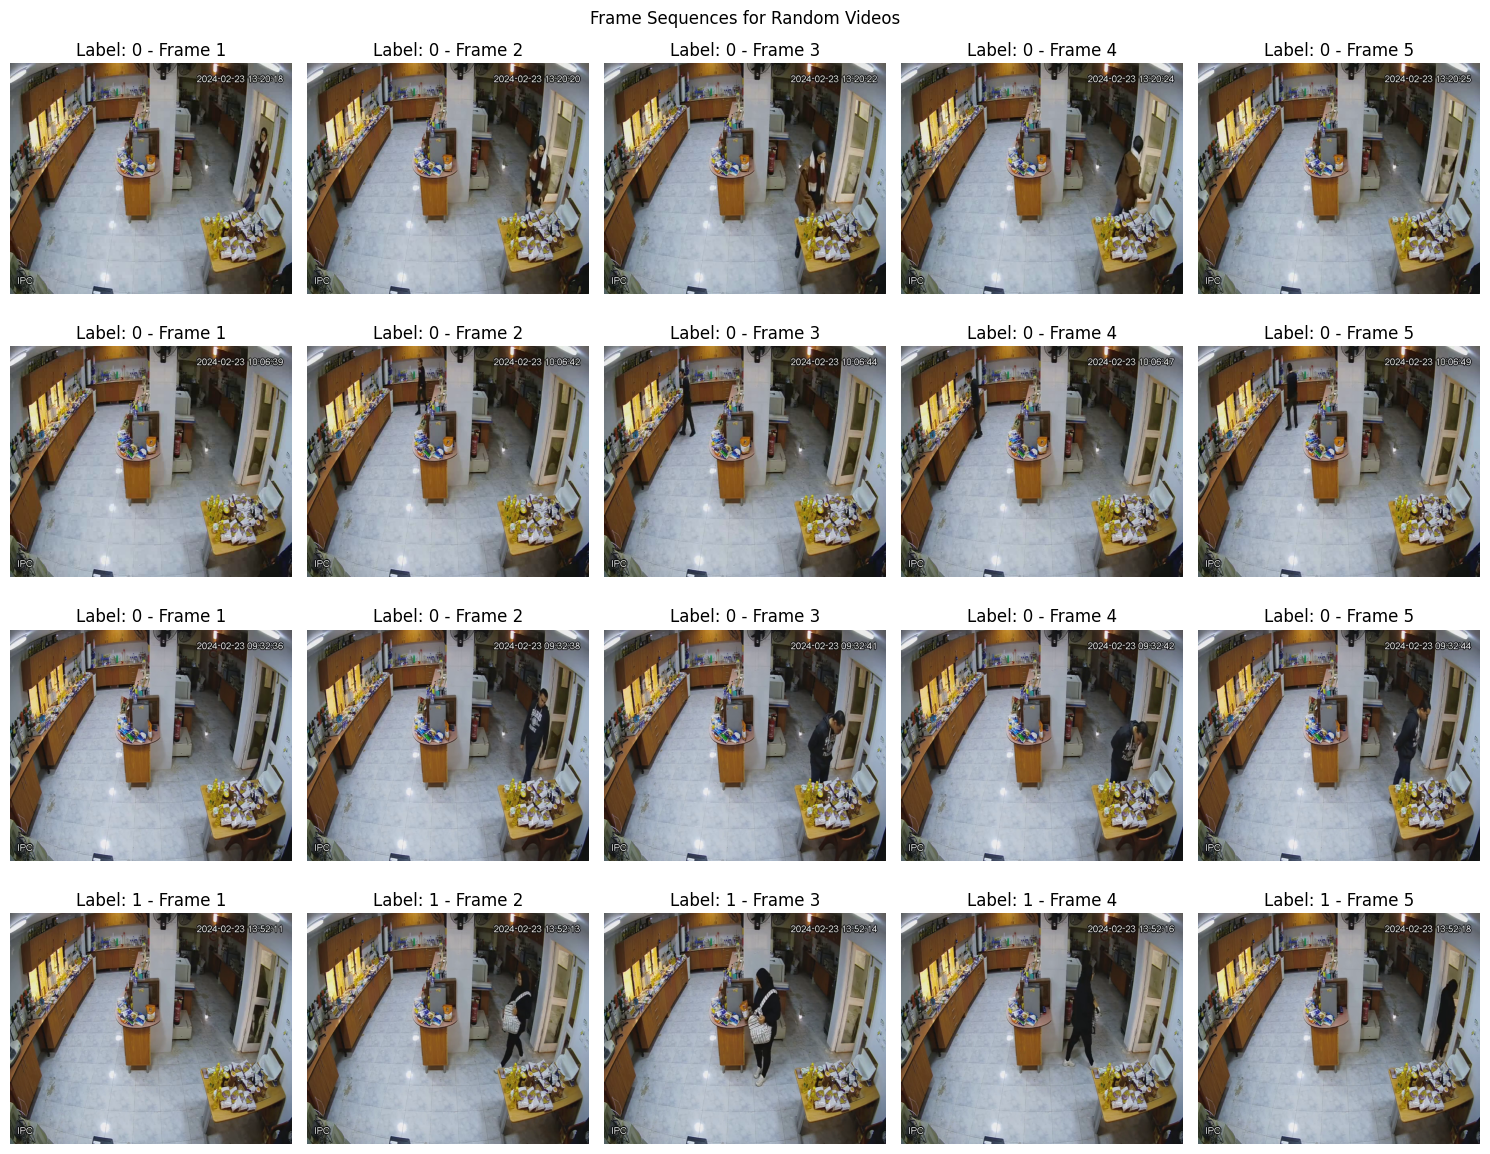

In [223]:
def visualize_frame_sequence(videos, labels, num_samples=4, num_frames=5):
    fig, axs = plt.subplots(num_samples, num_frames, figsize=(num_frames * 3, num_samples * 3))
    for i in range(num_samples):
        video_path = random.choice(videos)
        cap = cv2.VideoCapture(video_path)
        label = labels[videos.index(video_path)]
        frames = []
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        step = max(1, total_frames // num_frames)
        for j in range(num_frames):
            cap.set(cv2.CAP_PROP_POS_FRAMES, j * step)
            ret, frame = cap.read()
            if ret:
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(frame_rgb)
            else:
                frames.append(np.zeros((128, 128, 3)))
        cap.release()
        for j in range(num_frames):
            axs[i, j].imshow(frames[j])
            axs[i, j].set_title(f"Label: {label} - Frame {j+1}")
            axs[i, j].axis('off')
    plt.suptitle('Frame Sequences for Random Videos')
    plt.tight_layout()
    plt.show()


visualize_frame_sequence(videos, labels)

Shows a series of frames from a video to reveal motion patterns (e.g., a person grabbing items in shoplifting videos vs. walking in non-shoplifting).

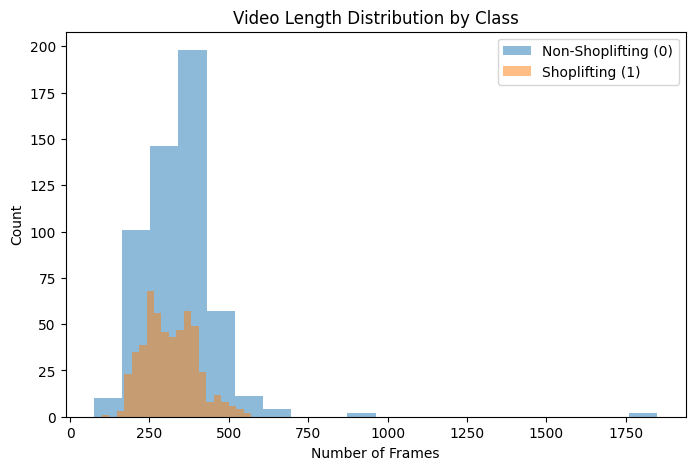

In [224]:
def visualize_video_lengths(videos, labels):
    lengths = []
    for v in videos:
        cap = cv2.VideoCapture(v)
        lengths.append(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
        cap.release()
    lengths_0 = [lengths[i] for i in range(len(labels)) if labels[i] == 0]
    lengths_1 = [lengths[i] for i in range(len(labels)) if labels[i] == 1]
    plt.figure(figsize=(8, 5))
    plt.hist(lengths_0, bins=20, alpha=0.5, label='Non-Shoplifting (0)')
    plt.hist(lengths_1, bins=20, alpha=0.5, label='Shoplifting (1)')
    plt.title('Video Length Distribution by Class')
    plt.xlabel('Number of Frames')
    plt.ylabel('Count')
    plt.legend()
    plt.show()


visualize_video_lengths(videos, labels)

Plots the length (in frames or seconds) of videos by class to check for imbalances in duration

In [225]:
# Visualization: Sample frames and histograms
def visualize_data(videos, labels, num_samples=5):
    fig, axs = plt.subplots(num_samples, 2, figsize=(10, 20))
    for i in range(num_samples):
        video_path = random.choice(videos)
        cap = cv2.VideoCapture(video_path)
        ret, frame = cap.read()
        if ret:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            axs[i, 0].imshow(frame_rgb)
            axs[i, 0].set_title(f"Label: {labels[videos.index(video_path)]}")
            axs[i, 0].axis('off')
            hist_r = cv2.calcHist([frame], [0], None, [256], [0, 256])
            hist_g = cv2.calcHist([frame], [1], None, [256], [0, 256])
            hist_b = cv2.calcHist([frame], [2], None, [256], [0, 256])
            axs[i, 1].plot(hist_r, color='r')
            axs[i, 1].plot(hist_g, color='g')
            axs[i, 1].plot(hist_b, color='b')
            axs[i, 1].set_title("Histogram")
        cap.release()
    plt.show()

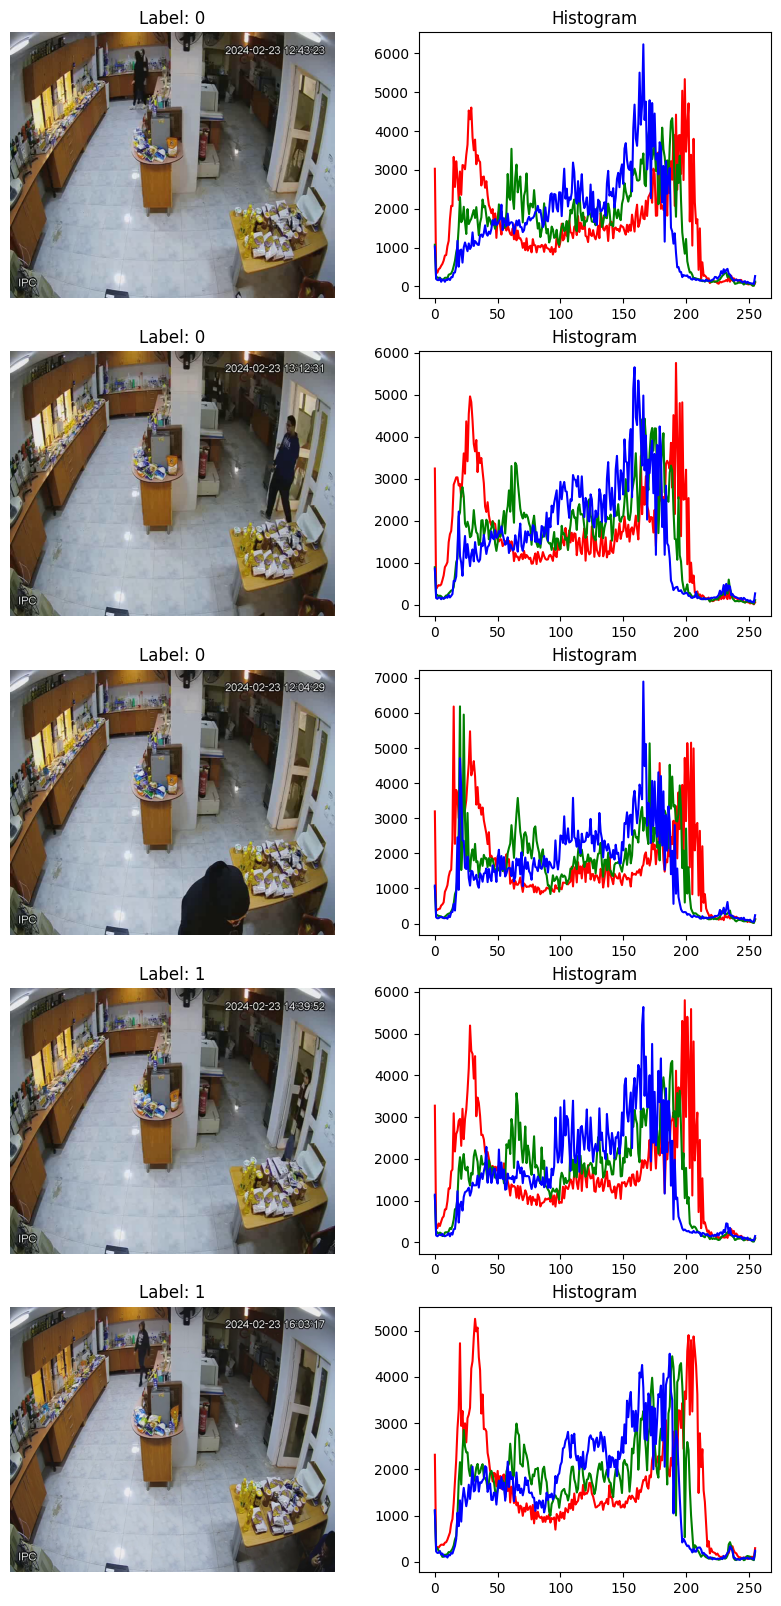

In [226]:
visualize_data(videos, labels)

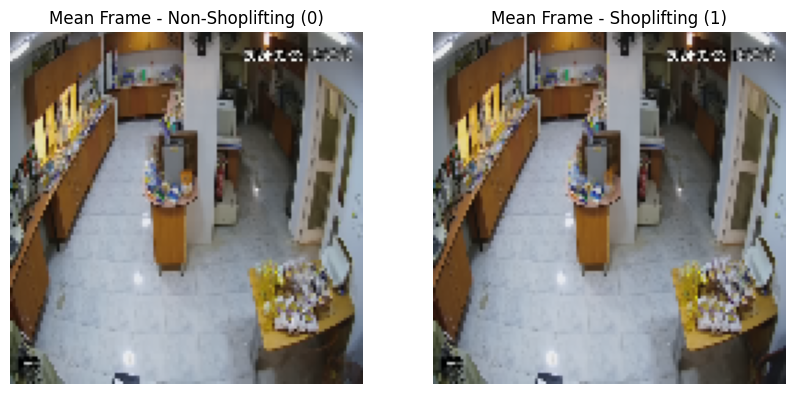

In [227]:
def visualize_mean_frame(videos, labels):
    mean_0 = np.zeros((128, 128, 3))
    mean_1 = np.zeros((128, 128, 3))
    count_0 = count_1 = 0
    for v, label in zip(videos, labels):
        cap = cv2.VideoCapture(v)
        ret, frame = cap.read()
        if ret:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_rgb = cv2.resize(frame_rgb, (128, 128)) / 255.0
            if label == 0:
                mean_0 += frame_rgb
                count_0 += 1
            else:
                mean_1 += frame_rgb
                count_1 += 1
        cap.release()
    mean_0 /= count_0 if count_0 > 0 else 1
    mean_1 /= count_1 if count_1 > 0 else 1
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(mean_0)
    axs[0].set_title('Mean Frame - Non-Shoplifting (0)')
    axs[0].axis('off')
    axs[1].imshow(mean_1)
    axs[1].set_title('Mean Frame - Shoplifting (1)')
    axs[1].axis('off')
    plt.show()


visualize_mean_frame(videos, labels)

Computes and displays the average frame across all videos in each class to see overall visual patterns (e.g., common colors or layouts in shoplifting scenes).

## Data Augmentation

In [249]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(64, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.ToTensor(),
])

In [250]:
def augment_video(video):
    # video shape: (T, C, H, W) -> apply transform per frame
    augmented_frames = [transform(frame) for frame in video]  # Should be (C, H, W)
    video_tensor = torch.stack(augmented_frames)  # Shape: (T, C, H, W)
    return video_tensor

## Models and Training

In [251]:
class VideoDataset(Dataset):
    def __init__(self, X, y, transform=None):
        # X shape: (N, T, H, W, C) -> transpose to (N, T, C, H, W)
        self.X = np.transpose(X, (0, 1, 4, 2, 3)).astype(np.float32)
        print(f"Dataset X shape: {self.X.shape}")  # Debug shape
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        video = torch.tensor(self.X[idx], dtype=torch.float32)
        if self.transform:
            video = augment_video(video)
        label = torch.tensor(self.y[idx], dtype=torch.float32).unsqueeze(0)
        return video, label

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=62, stratify=y)

train_dataset = VideoDataset(X_train, y_train, transform=transform)
val_dataset = VideoDataset(X_test, y_test, transform=None)

Dataset X shape: (849, 10, 3, 64, 64)
Dataset X shape: (213, 10, 3, 64, 64)


In [253]:
# Create DataLoader
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [254]:
class AttentionLayer(nn.Module):
    def __init__(self, in_features):
        super(AttentionLayer, self).__init__()
        self.W = nn.Parameter(torch.randn(in_features, 1))
        self.b = nn.Parameter(torch.zeros(10, 1))
        nn.init.xavier_uniform_(self.W)

    def forward(self, inputs):
        e = torch.tanh(torch.matmul(inputs, self.W) + self.b)
        a = torch.softmax(e.squeeze(-1), dim=-1)
        context = inputs * a.unsqueeze(-1)
        return torch.sum(context, dim=1)

In [255]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.weight = weight
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)  # Convert logits to probabilities
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        if self.weight is not None:
            weight = self.weight[targets.long()]  # Apply weight based on target class
        else:
            weight = torch.ones_like(targets)
        intersection = (inputs * targets * weight).sum()
        dice = (2. * intersection + self.smooth) / (inputs * weight).sum() + (targets * weight).sum() + self.smooth
        return 1 - dice

In [256]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import torch.nn.functional as F

# Train model with hybrid BCELoss and DiceLoss
def train_model(model, train_loader, val_loader, epochs=50, batch_size=8, device=device):
    # Collect all labels to compute class weights
    all_labels = []
    for _, labels in train_loader:
        all_labels.append(labels.cpu().numpy().flatten())  # Flatten to 1D
    all_labels = np.concatenate(all_labels).astype(int)  # Ensure integer type
    
    optimizer = optim.Adam(model.parameters(), lr=1e-5)
    class_counts = np.bincount(all_labels)
    num_samples = len(all_labels)
    class_weights = torch.tensor([num_samples / class_counts[0], num_samples / class_counts[1]], dtype=torch.float32).to(device)
    bce_loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
    dice_loss_fn = DiceLoss(weight=class_weights)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)  
    best_val_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        train_losses = []
        outputs = None
        for videos, labels in train_loader:
            videos, labels = videos.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(videos)
            bce_loss = bce_loss_fn(outputs, labels)
            dice_loss = dice_loss_fn(outputs, labels)
            loss = bce_loss + dice_loss
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        avg_train_loss = np.mean(train_losses)
        train_acc = ((torch.sigmoid(outputs) > 0.5).float() == labels).float().mean().item()
        train_f1 = f1_score(labels.cpu(), (torch.sigmoid(outputs) > 0.5).cpu().float(), zero_division=1)
        train_recall = recall_score(labels.cpu(), (torch.sigmoid(outputs) > 0.5).cpu().float(), zero_division=1)
        train_precision = precision_score(labels.cpu(), (torch.sigmoid(outputs) > 0.5).cpu().float(), zero_division=1)
        print(f"Epoch [{epoch+1}/{epochs}], Train Acc: {train_acc:.4f}, F1: {train_f1:.4f}, Recall: {train_recall:.4f}, Precision: {train_precision:.4f}")

        model.eval()
        val_losses = []
        with torch.no_grad():
            for videos, labels in val_loader:
                videos, labels = videos.to(device), labels.to(device)
                outputs = model(videos)
                bce_loss = bce_loss_fn(outputs, labels)
                dice_loss = dice_loss_fn(outputs, labels)
                loss = bce_loss + dice_loss
                val_losses.append(loss.item())
        avg_val_loss = np.mean(val_losses)
        scheduler.step(avg_val_loss)
        val_acc = ((torch.sigmoid(outputs) > 0.5).float() == labels).float().mean().item()
        val_f1 = f1_score(labels.cpu(), (torch.sigmoid(outputs) > 0.5).cpu().float(), zero_division=1)
        val_recall = recall_score(labels.cpu(), (torch.sigmoid(outputs) > 0.5).cpu().float(), zero_division=1)
        val_precision = precision_score(labels.cpu(), (torch.sigmoid(outputs) > 0.5).cpu().float(), zero_division=1)
        print(f"Epoch [{epoch+1}/{epochs}], Val Acc: {val_acc:.4f}, F1: {val_f1:.4f}, Recall: {val_recall:.4f}, Precision: {val_precision:.4f}")


        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print("Best model saved.")          

In [277]:
class CNNLSTM(nn.Module):
    def __init__(self, input_channels=3, hidden_dim=128): 
        super(CNNLSTM, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.4),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.4),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(start_dim=1)
        )
        self.lstm = nn.LSTM(64 * 8 * 8, 64, batch_first=True)  
        self.attention = AttentionLayer(64)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        B, T, C, H, W = x.shape
        cnn_out = []
        for t in range(T):
            frame = x[:, t, :, :, :]
            frame_out = self.cnn(frame)
            cnn_out.append(frame_out)
        cnn_out = torch.stack(cnn_out, dim=1)
        lstm_out, _ = self.lstm(cnn_out)
        attn_out = self.attention(lstm_out)
        out = self.fc(attn_out)
        return out


In [278]:
# Model 2: CNN with Attention
class CNNAttention(nn.Module):
    def __init__(self):
        super(CNNAttention, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.4),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.4),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(start_dim=1)
        )
        self.attention = AttentionLayer(64 * 8 * 8)
        self.fc = nn.Linear(64 * 8 * 8, 1)

    def forward(self, x):
        B, T, C, H, W = x.shape
        cnn_out = x.view(B * T, C, H, W)
        cnn_out = self.cnn(cnn_out).view(B, T, -1)
        attn_out = self.attention(cnn_out)
        out = self.fc(attn_out)
        return out

In [279]:
# Models
model1 = CNNLSTM().to(device)
model2 = CNNAttention().to(device)

In [280]:
y = np.array(labels, dtype=np.float32)

In [281]:
print("Training Model 1 (CNN-LSTM):")
train_model(model1, train_loader, val_loader, device=device)

Training Model 1 (CNN-LSTM):
Epoch [1/50], Train Acc: 0.0000, F1: 0.0000, Recall: 1.0000, Precision: 0.0000
Epoch [1/50], Val Acc: 0.2000, F1: 0.3333, Recall: 1.0000, Precision: 0.2000
Best model saved.
Epoch [2/50], Train Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000
Epoch [2/50], Val Acc: 0.2000, F1: 0.3333, Recall: 1.0000, Precision: 0.2000
Best model saved.
Epoch [3/50], Train Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000
Epoch [3/50], Val Acc: 0.2000, F1: 0.3333, Recall: 1.0000, Precision: 0.2000
Epoch [4/50], Train Acc: 0.0000, F1: 0.0000, Recall: 1.0000, Precision: 0.0000
Epoch [4/50], Val Acc: 0.2000, F1: 0.3333, Recall: 1.0000, Precision: 0.2000
Epoch [5/50], Train Acc: 0.0000, F1: 0.0000, Recall: 1.0000, Precision: 0.0000
Epoch [5/50], Val Acc: 0.2000, F1: 0.3333, Recall: 1.0000, Precision: 0.2000
Epoch [6/50], Train Acc: 0.0000, F1: 0.0000, Recall: 1.0000, Precision: 0.0000
Epoch [6/50], Val Acc: 0.2000, F1: 0.3333, Recall: 1.0000, Precision: 0.2000

In [282]:
print("Training Model 2 (CNN-Attention):")
train_model(model2, train_loader, val_loader, device=device)

Training Model 2 (CNN-Attention):
Epoch [1/50], Train Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000
Epoch [1/50], Val Acc: 0.2000, F1: 0.3333, Recall: 1.0000, Precision: 0.2000
Best model saved.
Epoch [2/50], Train Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000
Epoch [2/50], Val Acc: 0.2000, F1: 0.3333, Recall: 1.0000, Precision: 0.2000
Best model saved.
Epoch [3/50], Train Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000
Epoch [3/50], Val Acc: 0.2000, F1: 0.3333, Recall: 1.0000, Precision: 0.2000
Epoch [4/50], Train Acc: 0.0000, F1: 0.0000, Recall: 0.0000, Precision: 1.0000
Epoch [4/50], Val Acc: 0.2000, F1: 0.3333, Recall: 1.0000, Precision: 0.2000
Best model saved.
Epoch [5/50], Train Acc: 0.0000, F1: 0.0000, Recall: 1.0000, Precision: 0.0000
Epoch [5/50], Val Acc: 0.2000, F1: 0.3333, Recall: 1.0000, Precision: 0.2000
Best model saved.
Epoch [6/50], Train Acc: 0.0000, F1: 0.0000, Recall: 0.0000, Precision: 1.0000
Epoch [6/50], Val Acc: 0.2000, F1: 

## Evaluation

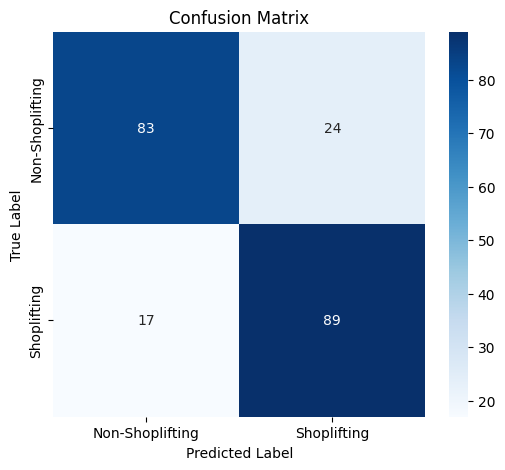

In [283]:
def plot_confusion_matrix(model, loader, device='cpu'):
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            y_pred.extend((output > 0.5).cpu().numpy().astype(int))
            y_true.extend(target.cpu().numpy().astype(int))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Shoplifting', 'Shoplifting'], yticklabels=['Non-Shoplifting', 'Shoplifting'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


plot_confusion_matrix(model1, val_loader, device=device)

In [284]:
def print_classification_report(model, loader, device='cpu'):
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            y_pred.extend((output > 0.5).cpu().numpy().astype(int))
            y_true.extend(target.cpu().numpy().astype(int))
    print(classification_report(y_true, y_pred, target_names=['Non-Shoplifting (0)', 'Shoplifting (1)']))

In [286]:
print("Model 1 Classification Report:")
print_classification_report(model1, val_loader, device=device)

Model 1 Classification Report:
                     precision    recall  f1-score   support

Non-Shoplifting (0)       0.83      0.78      0.80       107
    Shoplifting (1)       0.79      0.84      0.81       106

           accuracy                           0.81       213
          macro avg       0.81      0.81      0.81       213
       weighted avg       0.81      0.81      0.81       213



In [287]:
print("Model 2 Classification Report:")
print_classification_report(model2, val_loader, device=device)

Model 2 Classification Report:
                     precision    recall  f1-score   support

Non-Shoplifting (0)       1.00      0.09      0.17       107
    Shoplifting (1)       0.52      1.00      0.69       106

           accuracy                           0.54       213
          macro avg       0.76      0.55      0.43       213
       weighted avg       0.76      0.54      0.43       213



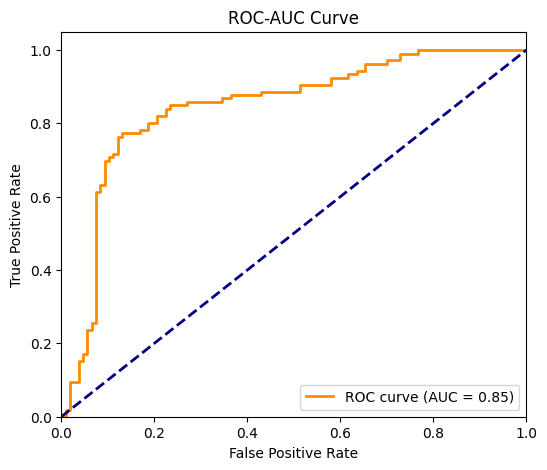

In [290]:
from sklearn.metrics import auc , roc_curve

def plot_roc_curve(model, loader, device='cpu'):
    model.eval()
    y_prob = []
    y_true = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            y_prob.extend(output.cpu().numpy())
            y_true.extend(target.cpu().numpy())
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve')
    plt.legend(loc='lower right')
    plt.show()


plot_roc_curve(model1, val_loader, device=device)

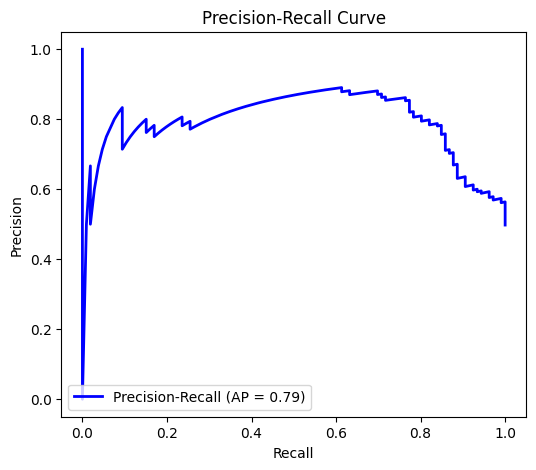

In [292]:
def plot_precision_recall(model, loader, device='cpu'):
    model.eval()
    y_prob = []
    y_true = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            y_prob.extend(output.cpu().numpy())
            y_true.extend(target.cpu().numpy())
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, lw=2, color='blue', label=f'Precision-Recall (AP = {ap:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()


plot_precision_recall(model1, val_loader, device=device)